In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional if you want a quick, cleaner boxplot


### Citations:
https://eccc-msc.github.io/open-data/msc-geomet/ogc_api_en/

In [2]:
# API endpoint
url = "https://api.weather.gc.ca/collections/climate-daily/items"
# Query parameters
provinces = ["BC", "AB", "NT"]
province_dict = {}
for province in provinces:
    params = {
        "datetime": "2019-01-01/2025-03-31",
        "limit": 10000,  # you can paginate if needed
        "PROVINCE_CODE": province,
    }
    # Make request
    response = requests.get(url, params=params)
    data = response.json()
    features = data["features"]
    records = [f["properties"] for f in features]
    province_dict[province] = pd.DataFrame(records)
    province_dict[province].to_csv(f"data/climate_data/monthly_{province}.csv", index=False)

monthly_climate_df_bc = province_dict["BC"]
monthly_climate_df_ab = province_dict["AB"]
monthly_climate_df_nwt = province_dict["NT"]

print(monthly_climate_df_bc.shape)
print(monthly_climate_df_ab.shape)
print(monthly_climate_df_nwt.shape)


(10000, 34)
(10000, 34)
(10000, 34)


---

# 1. Basic Explorations: Climate Data

In [3]:
df_list = [monthly_climate_df_bc, monthly_climate_df_ab, monthly_climate_df_nwt]

### A. Monthly Temperature & Precipitation Trends Over Time


What it shows:

- How mean temperature and total precipitation vary by month or year.

- Could hint at seasonal patterns that correlate with wildfires.

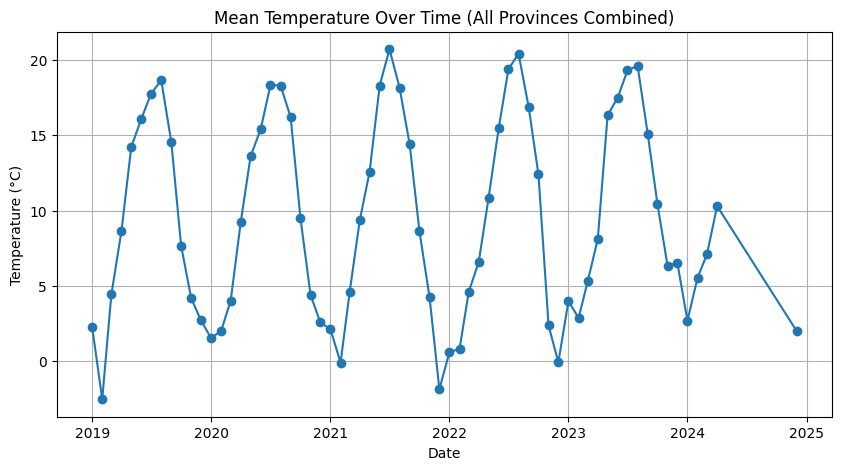

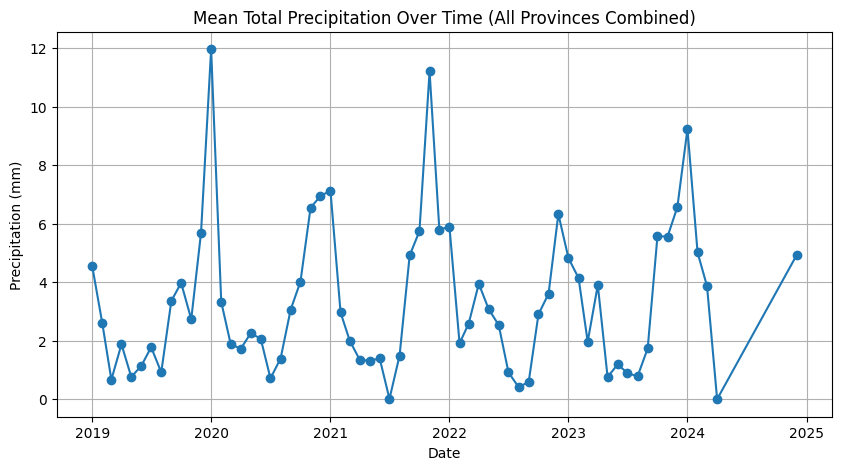

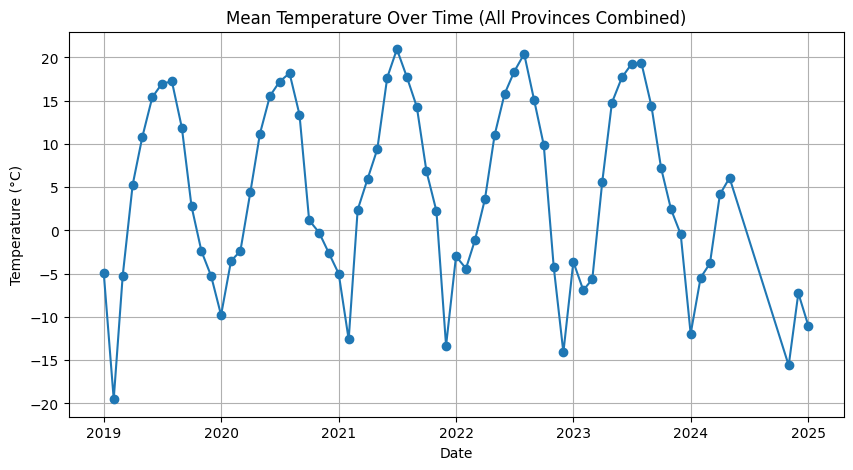

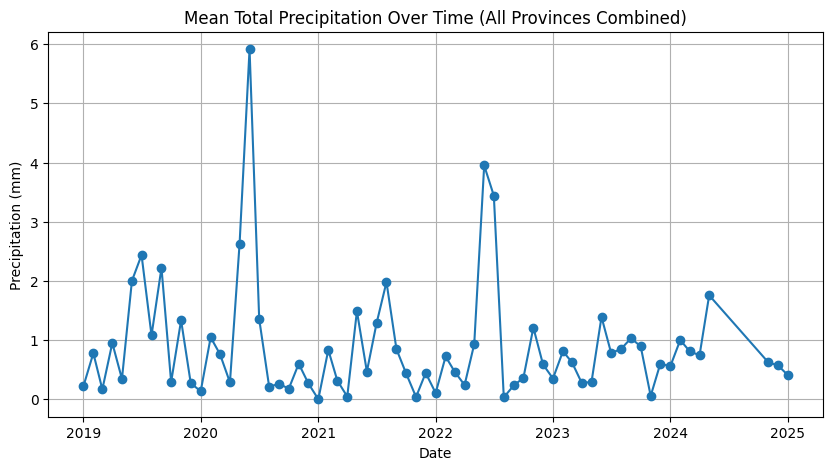

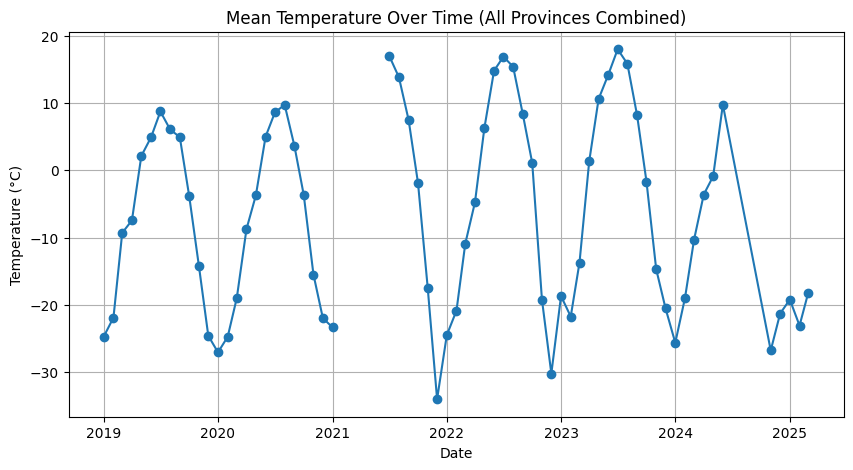

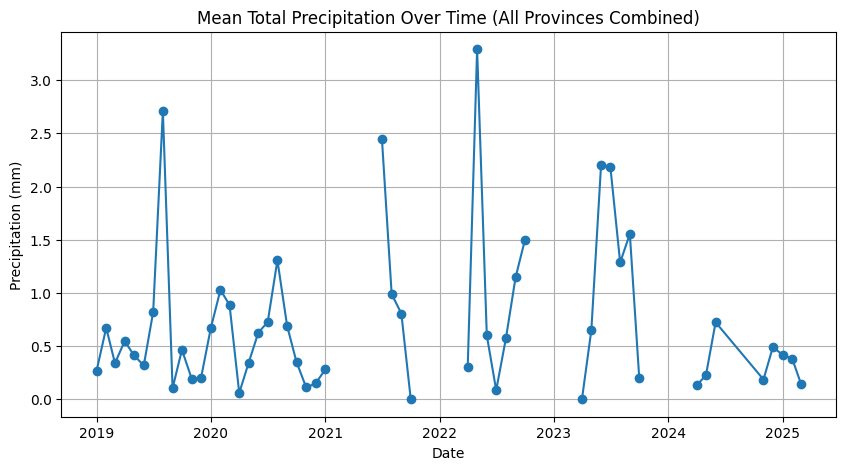

In [4]:
for df in df_list:
    # 1. Group climate data by LOCAL_YEAR and LOCAL_MONTH
    monthly_climate = (df
                    .groupby(['LOCAL_YEAR', 'LOCAL_MONTH'], as_index=False)
                    .agg({'MEAN_TEMPERATURE': 'mean',
                            'TOTAL_PRECIPITATION': 'mean'}))

    # 2. Create a time index (optional) for easier plotting
    monthly_climate['date'] = pd.to_datetime(
        monthly_climate['LOCAL_YEAR'].astype(str) + '-' + 
        monthly_climate['LOCAL_MONTH'].astype(str) + '-01'
    )

    # 3. Plot Temperature Over Time
    plt.figure(figsize=(10, 5))
    plt.plot(monthly_climate['date'], monthly_climate['MEAN_TEMPERATURE'], marker='o')
    plt.title('Mean Temperature Over Time (All Provinces Combined)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)
    plt.show()

    # 4. Plot Precipitation Over Time
    plt.figure(figsize=(10, 5))
    plt.plot(monthly_climate['date'], monthly_climate['TOTAL_PRECIPITATION'], marker='o')
    plt.title('Mean Total Precipitation Over Time (All Provinces Combined)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()


Interpretation:

- Look for a seasonal cycle (peaks in summer vs. winter) or any trends over the years.

- Compare these patterns to wildfire frequency or severity in the same periods.



## B. Box Plot by Month (Seasonality)

What it shows:

Seasonal distribution of mean temperature or precipitation across months (1–12).

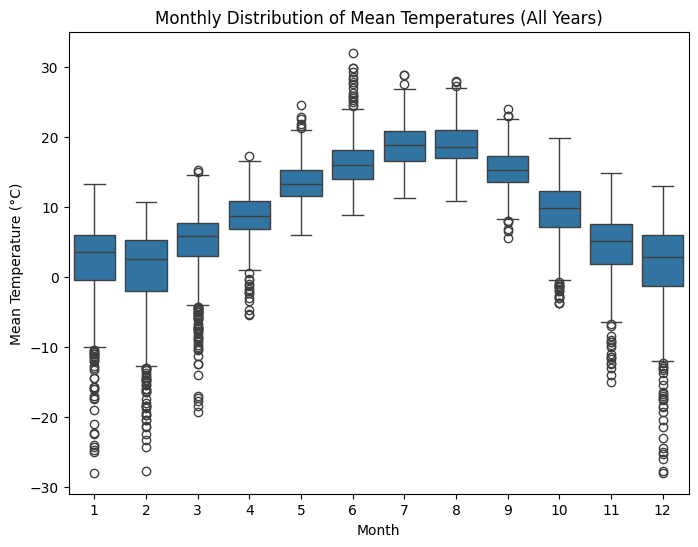

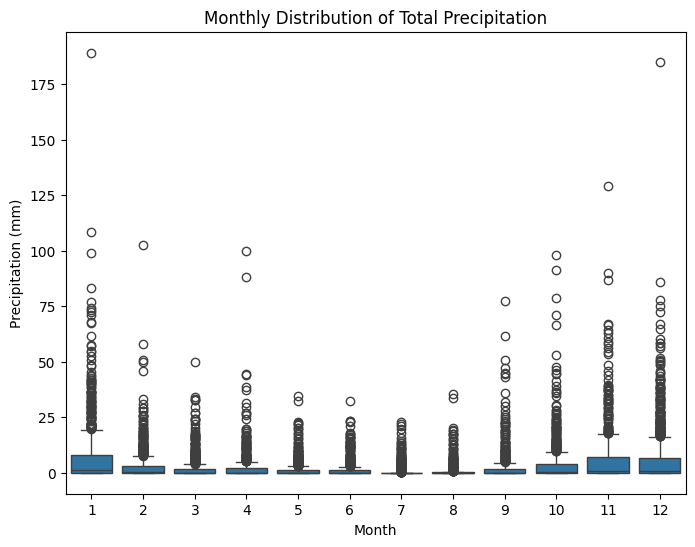

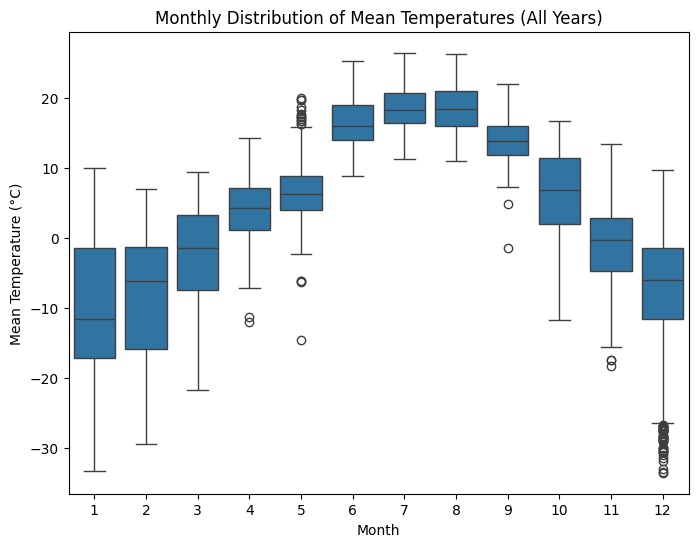

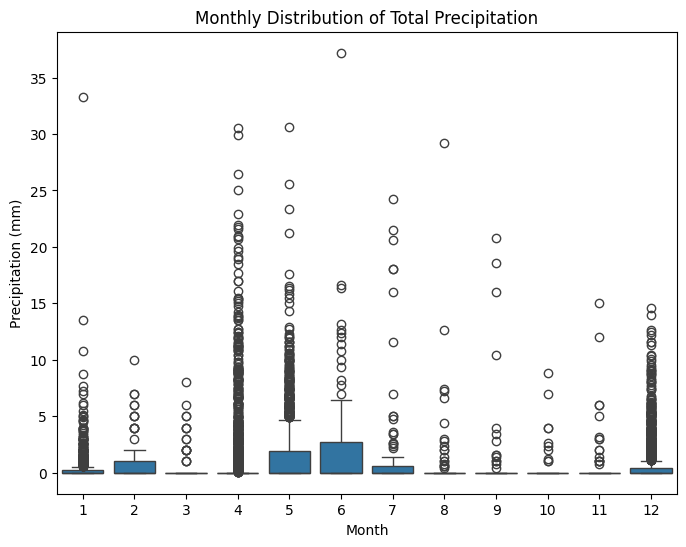

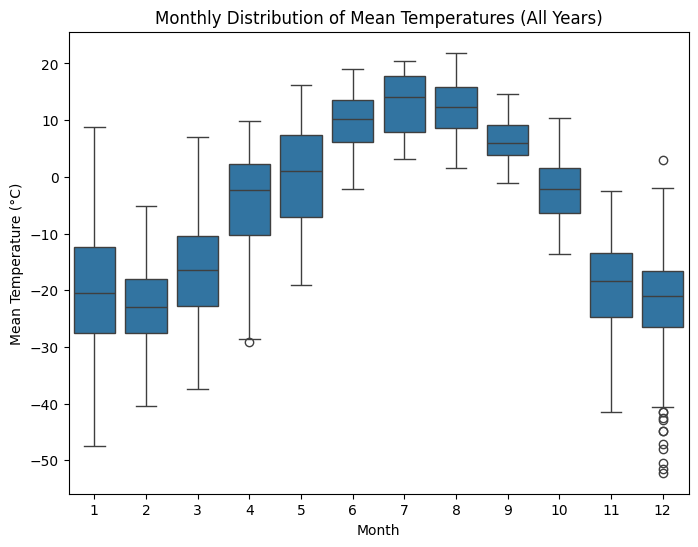

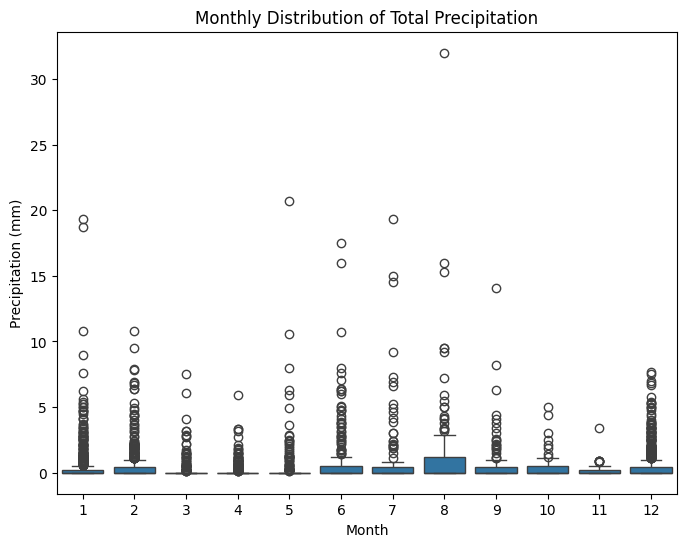

In [5]:
for df in df_list:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='LOCAL_MONTH', y='MEAN_TEMPERATURE', data=df)
    plt.title('Monthly Distribution of Mean Temperatures (All Years)')
    plt.xlabel('Month')
    plt.ylabel('Mean Temperature (°C)')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='LOCAL_MONTH', y='TOTAL_PRECIPITATION', data=df)
    plt.title('Monthly Distribution of Total Precipitation')
    plt.xlabel('Month')
    plt.ylabel('Precipitation (mm)')
    plt.show()

Interpretation:

Quickly see which months are hottest/coldest and which are wettest/driest, providing clues about wildfire-prone periods.

In [6]:
# -------------------------------
# PREPARE THE DATA
# -------------------------------
# Assume monthly_climate_df_bc, monthly_climate_df_ab, monthly_climate_df_nwt are already defined.
# Add a Province identifier to each DataFrame.
monthly_climate_df_bc['Province'] = 'BC'
monthly_climate_df_ab['Province'] = 'AB'
monthly_climate_df_nwt['Province'] = 'NT'

# Combine into one DataFrame for easier comparison
monthly_climate_all = pd.concat(
    [monthly_climate_df_bc, monthly_climate_df_ab, monthly_climate_df_nwt],
    ignore_index=True
)

# Create a proper date column for time series plotting
monthly_climate_all['date'] = pd.to_datetime(
    monthly_climate_all['LOCAL_YEAR'].astype(str) + '-' +
    monthly_climate_all['LOCAL_MONTH'].astype(str) + '-01'
)


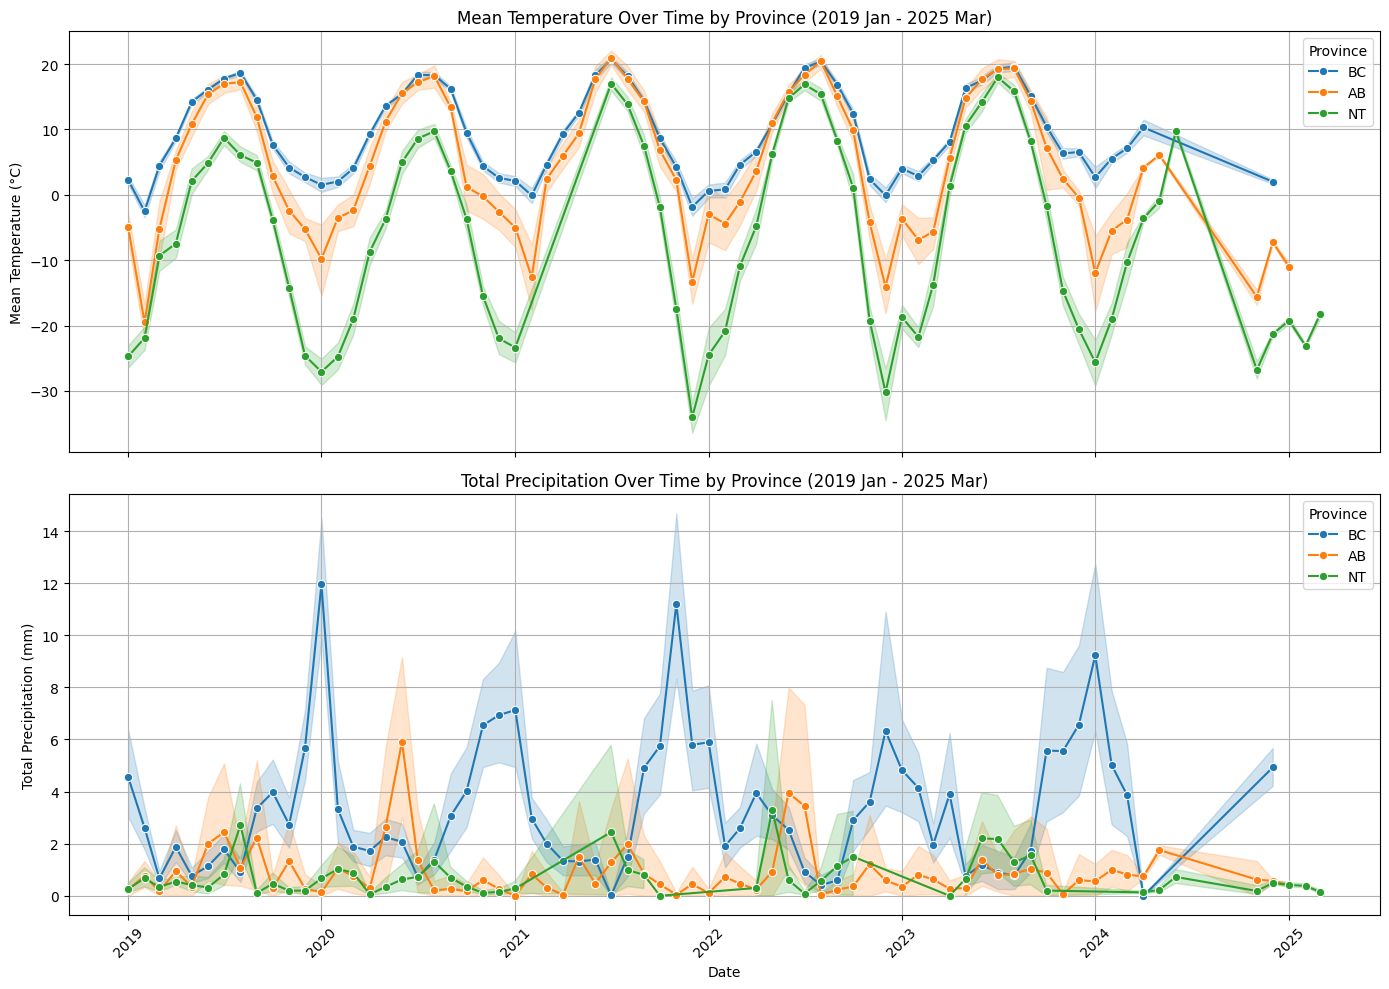

In [7]:
# -------------------------------
# Visualization 1: Time Series Comparison
# -------------------------------
# Create a combined line plot with subplots for Temperature and Precipitation.
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Mean Temperature Over Time by Province
sns.lineplot(
    ax=axes[0],
    data=monthly_climate_all,
    x='date',
    y='MEAN_TEMPERATURE',
    hue='Province',
    marker='o'
)
axes[0].set_title('Mean Temperature Over Time by Province (2019 Jan - 2025 Mar)')
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Temperature (°C)')
axes[0].grid(True)

# Plot Total Precipitation Over Time by Province
sns.lineplot(
    ax=axes[1],
    data=monthly_climate_all,
    x='date',
    y='TOTAL_PRECIPITATION',
    hue='Province',
    marker='o'
)
axes[1].set_title('Total Precipitation Over Time by Province (2019 Jan - 2025 Mar)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Precipitation (mm)')
axes[1].grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


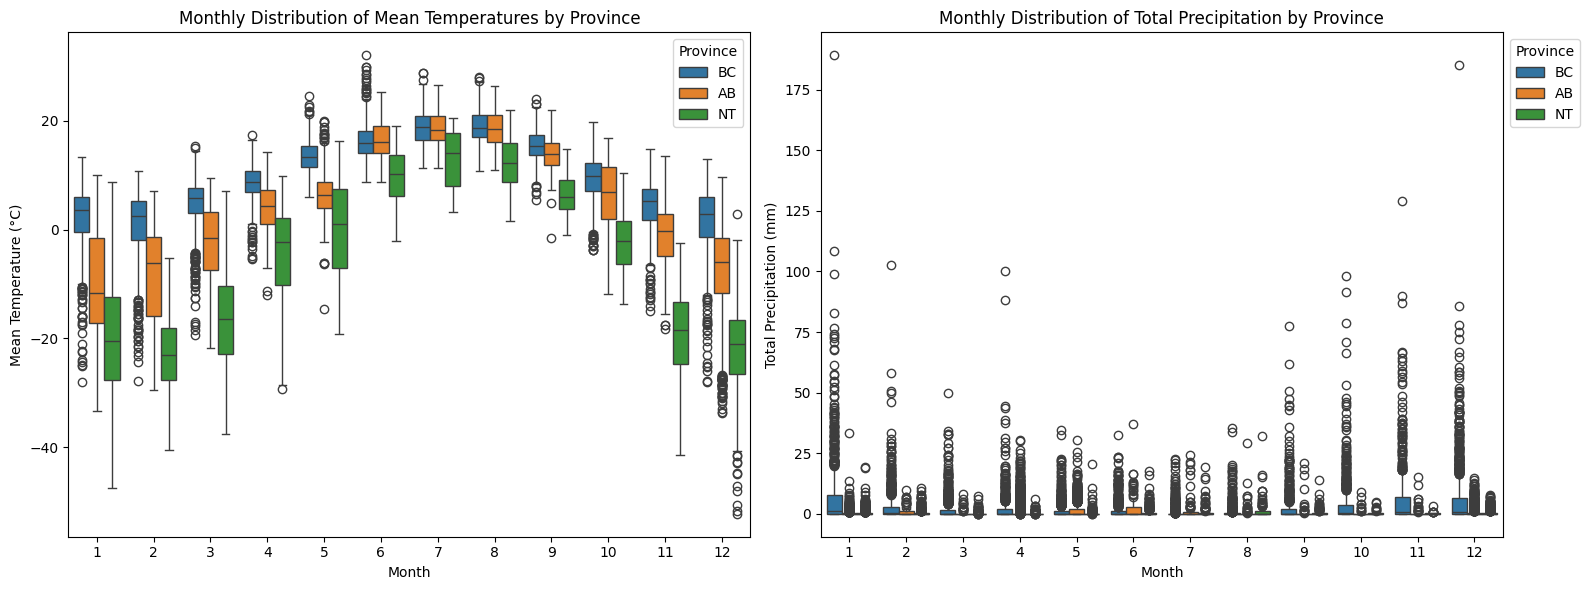

In [8]:

# -------------------------------
# Visualization 2: Seasonal Distribution via Box Plots
# -------------------------------
# Instead of individual plots per DataFrame, we now plot the monthly distribution of 
# Mean Temperature and Total Precipitation for all provinces side-by-side.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for Monthly Distribution of Mean Temperature
sns.boxplot(
    ax=axes[0],
    x='LOCAL_MONTH',
    y='MEAN_TEMPERATURE',
    hue='Province',
    data=monthly_climate_all
)
axes[0].set_title('Monthly Distribution of Mean Temperatures by Province')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Mean Temperature (°C)')
axes[0].legend(title='Province', bbox_to_anchor=(1,1))

# Boxplot for Monthly Distribution of Total Precipitation
sns.boxplot(
    ax=axes[1],
    x='LOCAL_MONTH',
    y='TOTAL_PRECIPITATION',
    hue='Province',
    data=monthly_climate_all
)
axes[1].set_title('Monthly Distribution of Total Precipitation by Province')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Precipitation (mm)')
axes[1].legend(title='Province', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()